In [1]:
# Import Libraries 
from IPython.display import HTML

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output
import optuna

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# Read input files in pd
dfTrain = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col = 'id')
dfTest = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col = 'id')
dfSubmission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')
target = 'Premium Amount'

In [3]:
# View data before preprocess
print('--- Train (% missing) ---')
print(100*dfTrain.isnull().sum() / dfTrain.shape[0])
print('--- Test (% missing) ---')
print(100*dfTest.isnull().sum() / dfTest.shape[0])

print(dfTrain.shape)
print(dfTest.shape)

--- Train (% missing) ---
Age                      1.558750
Gender                   0.000000
Annual Income            3.745750
Marital Status           1.544083
Number of Dependents     9.139333
Education Level          0.000000
Occupation              29.839583
Health Score             6.173000
Location                 0.000000
Policy Type              0.000000
Previous Claims         30.335750
Vehicle Age              0.000500
Credit Score            11.490167
Insurance Duration       0.000083
Policy Start Date        0.000000
Customer Feedback        6.485333
Smoking Status           0.000000
Exercise Frequency       0.000000
Property Type            0.000000
Premium Amount           0.000000
dtype: float64
--- Test (% missing) ---
Age                      1.561125
Gender                   0.000000
Annual Income            3.732500
Marital Status           1.542000
Number of Dependents     9.141250
Education Level          0.000000
Occupation              29.890625
Health Score    

In [4]:
# Preprocess and Loss Function
def preprocess(df):
    # Policy Start Date FE
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Policy Start Year'] = df['Policy Start Date'].dt.year
    df['Policy Start Month'] = df['Policy Start Date'].dt.month
    df['Policy Start Quarter'] = df['Policy Start Date'].dt.quarter
    df['Policy Start Month Sin'] = np.sin(2 * np.pi * df['Policy Start Month'] / 12)
    df['Policy Start Month Cos'] = np.cos(2 * np.pi * df['Policy Start Month'] / 12)
    df['Policy Start Quarter Sin'] = np.sin(2 * np.pi * df['Policy Start Quarter'] / 4)
    df['Policy Start Quarter Cos'] = np.cos(2 * np.pi * df['Policy Start Quarter'] / 4)
    df = df.drop(columns=['Policy Start Date'])

    # Feature Mapping
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    df['Smoking Status'] = df['Smoking Status'].map({'No': 0, 'Yes': 1})
    
    df['Previous Claims'] = df['Previous Claims'].clip(None, 8) 
    df['Health Score'] = df['Health Score'].apply(lambda x: int(x) if pd.notna(x) else x)
    df['Credit Score'] = df['Credit Score'].apply(lambda x: int(x) if pd.notna(x) else x)
    df['Credit_missing'] = df['Credit Score'].isnull().astype(int)
    df['Claims_missing'] = df['Previous Claims'].isnull().astype(int)
    
    df['Number of Dependents'] = df['Number of Dependents'].fillna(0)
    df['Annual Income'] = np.log1p(df['Annual Income'])
    df['Income per Dependent'] = df['Annual Income']/(df['Number of Dependents'] + 1)

    # df['Annual Income'] = df['Annual Income'].fillna(np.mean(df['Annual Income']))
    # df['Credit Score'] = df['Credit Score'].fillna(max(min(df['Credit Score']), 0))
    # df['Education Level'] = df['Education Level'].fillna("High School")
    # df['Customer Feedback'] = df['Customer Feedback'].fillna("Average")
    
    # numColumns = [col for col in df.select_dtypes(include=["number"]).columns if col != "Premium Amount"]
    catColumns = ['Marital Status','Education Level','Occupation','Location','Policy Type','Customer Feedback','Exercise Frequency','Property Type']

    # for col in numColumns: df[f"{col}_missing"] = df[col].isna()
    for c in catColumns: df[c].fillna("missing", inplace=True)
    df = ordinal_mapping(df, catColumns) 
    
    return df

def ordinal_mapping(df, catColumns):
    # Ordinal Mapping
    ordinal_mappings = {
        "Education Level": ["missing", "High School", "Bachelor's", "Master's", "PhD"],
        "Customer Feedback": ["missing", "Poor", "Average", "Good"],
        "Exercise Frequency": ["missing", "Rarely", "Monthly", "Weekly", "Daily"],
        "Policy Type": ["missing", "Basic", "Comprehensive", "Premium"]}

    encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_mappings])
    columns_to_encode = list(ordinal_mappings.keys())
    df[columns_to_encode] = encoder.fit_transform(df[columns_to_encode])

    # One-hot encoding
    non_ordinal_columns = [c for c in catColumns if c not in ordinal_mappings]
    df = pd.get_dummies(df, columns=[c for c in non_ordinal_columns], drop_first=True) 
    return df

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [5]:
# Preprocess 
dfTrain = preprocess(dfTrain)
dfTest = preprocess(dfTest)

In [6]:
# View data after preprocess
print('--- Train (% missing) ---')
print(100*dfTrain.isnull().sum() / dfTrain.shape[0])
print('--- Test (% missing) ---')
print(100*dfTest.isnull().sum() / dfTest.shape[0])

print(dfTrain.shape)
print(dfTest.shape)

--- Train (% missing) ---
Age                          1.558750
Gender                       0.000000
Annual Income                3.745750
Number of Dependents         0.000000
Education Level              0.000000
Health Score                 6.173000
Policy Type                  0.000000
Previous Claims             30.335750
Vehicle Age                  0.000500
Credit Score                11.490167
Insurance Duration           0.000083
Customer Feedback            0.000000
Smoking Status               0.000000
Exercise Frequency           0.000000
Premium Amount               0.000000
Policy Start Year            0.000000
Policy Start Month           0.000000
Policy Start Quarter         0.000000
Policy Start Month Sin       0.000000
Policy Start Month Cos       0.000000
Policy Start Quarter Sin     0.000000
Policy Start Quarter Cos     0.000000
Credit_missing               0.000000
Claims_missing               0.000000
Income per Dependent         3.745750
Marital Status_Married  

In [7]:
# Define the target column and separate features and target
X = dfTrain.drop(columns=[target])
y = np.log1p(dfTrain[target])

In [8]:
# Model training and feature importance function
def kfold_cv(X, y, model_class, model_id, model_params, n_splits, X_test):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metric_sum = 0
    train_predictions = np.zeros(len(X))
    test_predictions = np.zeros(len(X_test))  
    feature_importances = np.zeros(X.shape[1])

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}...")
        
        # Split data into training and validation sets for this fold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Initialize and train the XGBoost model
        model = model_class(**model_params)

        fit_params = {
            '0': {
                'eval_set': [(X_val, y_val)],
                'verbose': False,
                'early_stopping_rounds': 50,
                'eval_metric': 'rmse'
            },
            '1': {  
                'eval_set': [(X_val, y_val)],
                'eval_metric': 'rmse'
            },
            '2': {
                'early_stopping_rounds': 50
            }
        }
        params = fit_params.get(model_id, {})
        model.fit(X_train, y_train, **params)
        
        # Make predictions on validation set
        y_pred = model.predict(X_val)
        fold_metric = rmse(y_val, y_pred)
        fold_metric_sum += fold_metric
        print(f"Fold {fold + 1} Metric: {fold_metric:.5f}")
        
        # Accumulate feature importances if the model supports it
        feature_importances += model.feature_importances_ / n_splits
        
        train_predictions[train_idx] += model.predict(X_train) / n_splits  # Accumulate train predictions
        test_predictions += model.predict(X_test) / n_splits

    avg_metric = fold_metric_sum / n_splits
    print(f"Average Metric (RMSLE) across {n_splits} folds: {avg_metric:.5f}")
    
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names,'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
    print("Feature Importances:")
    print(importance_df)
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Averaged Across Folds)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return train_predictions, test_predictions


In [9]:
# Model training and feature importance function with K-Fold
def kfold_cv(X, y, model_class, model_id, model_params, n_splits, X_test):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metric_sum = 0
    train_predictions = np.zeros(len(X))
    test_predictions = np.zeros(len(X_test))  
    feature_importances = np.zeros(X.shape[1])

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}...")
        
        # Split data into training and validation sets for this fold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Initialize and train the model
        model = model_class(**model_params)
        
        fit_params = {
            '0': {
                'eval_set': [(X_val, y_val)],
                'verbose': False,
                'early_stopping_rounds': 50,
                'eval_metric': 'rmse'
            },
            '1': {  
                'eval_set': [(X_val, y_val)],
                'eval_metric': 'rmse'
            },
            '2': {
                'task_type': 'GPU'
            }
        }
        params = fit_params.get(model_id, {})
        model.fit(X_train, y_train, **params)
        
        # Make predictions on validation set
        y_pred = model.predict(X_val)
        fold_metric = rmse(y_val, y_pred)
        fold_metric_sum += fold_metric
        print(f"Fold {fold + 1} Metric: {fold_metric:.5f}")
        
        # Accumulate feature importances if the model supports it
        feature_importances += model.feature_importances_ / n_splits
        
        train_predictions[train_idx] += model.predict(X_train) / n_splits  # Accumulate train predictions
        test_predictions += model.predict(X_test) / n_splits

    avg_metric = fold_metric_sum / n_splits
    print(f"Average Metric (RMSLE) across {n_splits} folds: {avg_metric:.5f}")
    
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
    print("Feature Importances:")
    print(importance_df)
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Averaged Across Folds)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return train_predictions, test_predictions


Training fold 1...
Fold 1 Metric: 1.04623
Training fold 2...
Fold 2 Metric: 1.04660
Training fold 3...
Fold 3 Metric: 1.04765
Training fold 4...
Fold 4 Metric: 1.04356
Training fold 5...
Fold 5 Metric: 1.04814
Training fold 6...
Fold 6 Metric: 1.04453
Training fold 7...
Fold 7 Metric: 1.04379
Training fold 8...
Fold 8 Metric: 1.04512
Training fold 9...
Fold 9 Metric: 1.04225
Training fold 10...
Fold 10 Metric: 1.04987
Average Metric (RMSLE) across 10 folds: 1.04577
Feature Importances:
                     Feature  Importance
21            Credit_missing    0.143965
7            Previous Claims    0.123921
11         Customer Feedback    0.119641
26    Marital Status_missing    0.092850
2              Annual Income    0.090450
9               Credit Score    0.077307
14         Policy Start Year    0.059963
5               Health Score    0.059141
23      Income per Dependent    0.034336
22            Claims_missing    0.033014
3       Number of Dependents    0.024509
29        Occupat

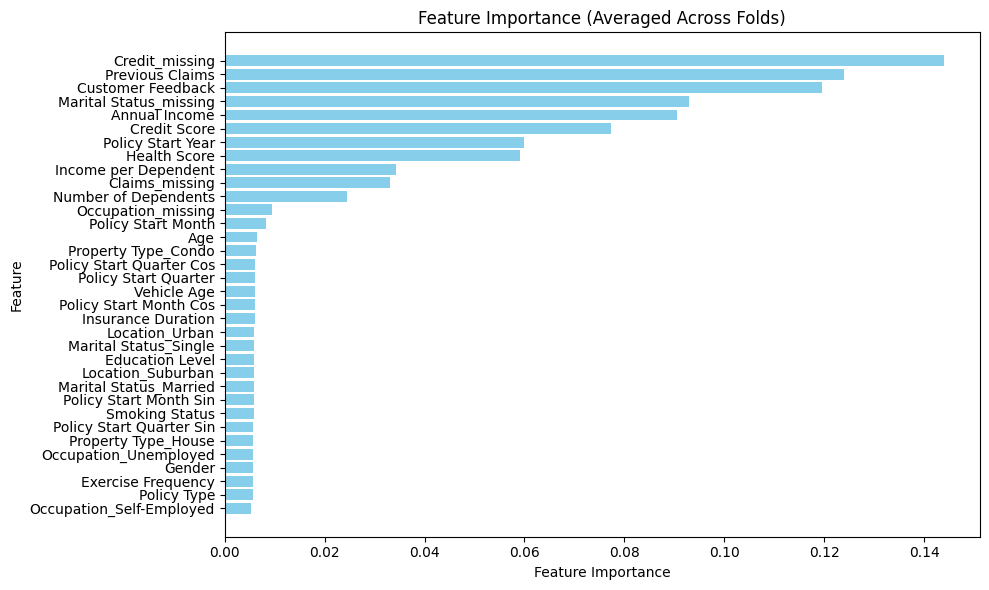

In [10]:
# XGB Model
xgb_params = {
    'device': 'cuda',
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'sub_sample': 0.6,
    'learning_rate': 0.07,
    'colsample_bytree': 0.7,
    'lambda': 6,
    'alpha': 4,
    'n_jobs': -1,
    'random_state': 42
}

# Drop least impactful metric(s) from later testing
cols_to_drop_XGB = []

# Drop the specified columns from both train and test datasets
X_xgb = X.drop(columns=cols_to_drop_XGB)
test_xgb = dfTest.drop(columns=cols_to_drop_XGB)
xgb_train_pred, xgb_test_pred = kfold_cv(X_xgb, y, xgb.XGBRegressor, 0, xgb_params, 10, test_xgb)

# Reverse log transformation for test predictions
y_test_pred_xgb = np.expm1(xgb_test_pred)

Training fold 1...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 Metric: 1.04640
Training fold 2...
Fold 2 Metric: 1.04666
Training fold 3...
Fold 3 Metric: 1.04772
Training fold 4...
Fold 4 Metric: 1.04338
Training fold 5...
Fold 5 Metric: 1.04835
Training fold 6...
Fold 6 Metric: 1.04451
Training fold 7...
Fold 7 Metric: 1.04358
Training fold 8...
Fold 8 Metric: 1.04509
Training fold 9...
Fold 9 Metric: 1.04177
Training fold 10...
Fold 10 Metric: 1.04988
Average Metric (RMSLE) across 10 folds: 1.04573
Feature Importances:
                     Feature  Importance
9               Credit Score      4148.3
2              Annual Income      4088.9
5               Health Score      3181.5
23      Income per Dependent      2632.7
0                        Age      2452.8
8                Vehicle Age      1599.3
7            Previous Claims      1498.0
10        Insurance Duration      1090.4
14         Policy Start Year       995.5
11         Customer Feedback       820.0
18    Policy Start Month Cos       659.6
15        Policy Start Month       6

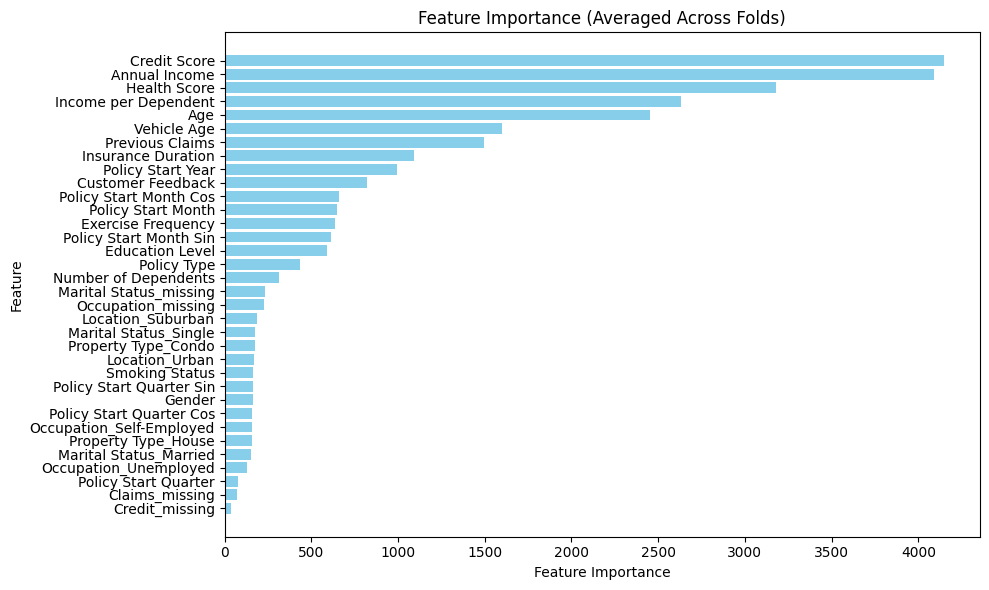

In [11]:
# LGB Model
lgb_params = {
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'max_depth': 11,
    'reg_alpha': 0.6571665413916834,
    'reg_lambda': 9.708571261009048,
    'num_leaves': 30,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
    'device': 'gpu'
}

# Drop least impactful metric(s) from later testing
cols_to_drop_LGB = []

# Drop the specified columns from both train and test datasets
X_lgb = X.drop(columns=cols_to_drop_LGB)
test_lgb = dfTest.drop(columns=cols_to_drop_LGB)
lgb_train_pred, lgb_test_pred = kfold_cv(X_lgb, y, lgb.LGBMRegressor, 1, lgb_params, 10, test_lgb)

# Reverse log transformation for test predictions
y_test_pred_lgb = np.expm1(lgb_test_pred)

Training fold 1...
Fold 1 Metric: 1.04843
Training fold 2...
Fold 2 Metric: 1.04915
Training fold 3...
Fold 3 Metric: 1.04989
Training fold 4...
Fold 4 Metric: 1.04562
Training fold 5...
Fold 5 Metric: 1.05028
Training fold 6...
Fold 6 Metric: 1.04686
Training fold 7...
Fold 7 Metric: 1.04586
Training fold 8...
Fold 8 Metric: 1.04719
Training fold 9...
Fold 9 Metric: 1.04453
Training fold 10...
Fold 10 Metric: 1.05233
Average Metric (RMSLE) across 10 folds: 1.04801
Feature Importances:
                     Feature  Importance
2              Annual Income   27.424808
9               Credit Score   20.434476
5               Health Score   10.065160
7            Previous Claims    7.544131
23      Income per Dependent    6.568528
11         Customer Feedback    3.757330
14         Policy Start Year    3.457521
0                        Age    3.207354
8                Vehicle Age    2.406855
10        Insurance Duration    1.799536
21            Credit_missing    1.736468
26    Marital Sta

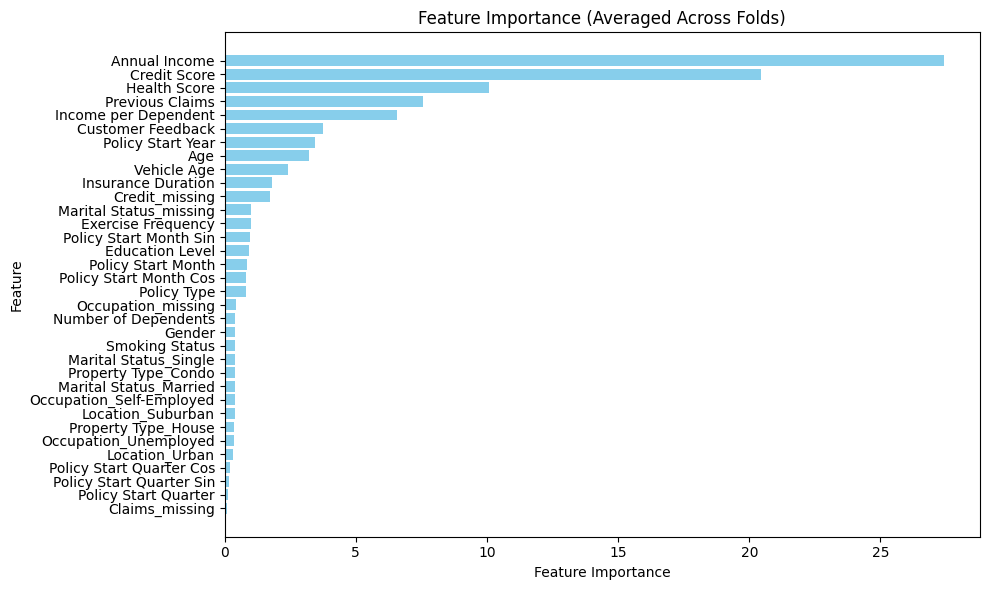

In [12]:
# CAT Boost Model
cat_params = {
    'iterations': 612, 
    'depth': 8, 
    'learning_rate': 0.15847175187493337, 
    'l2_leaf_reg': 0.6858238271761297, 
    'loss_function': 'RMSE',
    'random_state': 42,
    'verbose': False,
    'thread_count' : -1
}

cat_train_pred, cat_test_pred = kfold_cv(X, y, cb.CatBoostRegressor, 2, cat_params, 10, dfTest)

# Reverse log transformation for test predictions
y_test_pred_cat = np.expm1(cat_test_pred)

In [13]:
def ensemble_prep(results):
    ret = np.expm1(results)
    ret = np.clip(ret, 20, 4999)
    return ret

In [14]:
'''
# L2 Ensemble (LASSO)
m1 = ensemble_prep(xgb_train_pred)
m2 = ensemble_prep(lgb_train_pred)
m3 = ensemble_prep(cat_train_pred)

n1 = ensemble_prep(xgb_test_pred)
n2 = ensemble_prep(lgb_test_pred)
n3 = ensemble_prep(cat_test_pred)

meta_train = np.column_stack([m1,m2,m3]) 
meta_test = np.column_stack([n1,n2,n3])
meta_y = np.expm1(y)

X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(meta_train, meta_y, test_size=0.2, random_state=42)

lasso_meta_model = Lasso(alpha=1)  # Adjust alpha for regularization strength
lasso_meta_model.fit(X_train_meta, y_train_meta)
val_predictions = lasso_meta_model.predict(X_val_meta)
val_predictions_c = np.clip(val_predictions, 20, 4999)

# RMSLE calculation
ensemble_rmsle = np.sqrt(mean_squared_log_error(y_val_meta, val_predictions_c))
print(f'Ensemble Lasso RMSLE: {ensemble_rmsle:.5f}')

# Predict on actual test
final_predictions = lasso_meta_model.predict(meta_test)
final_predictions_c = np.clip(final_predictions, 20, 4999)

# Print the feature importances (coefficients)
feature_importances = lasso_meta_model.coef_
importance_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'CatBoost'],
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)
'''

"\n# L2 Ensemble (LASSO)\nm1 = ensemble_prep(xgb_train_pred)\nm2 = ensemble_prep(lgb_train_pred)\nm3 = ensemble_prep(cat_train_pred)\n\nn1 = ensemble_prep(xgb_test_pred)\nn2 = ensemble_prep(lgb_test_pred)\nn3 = ensemble_prep(cat_test_pred)\n\nmeta_train = np.column_stack([m1,m2,m3]) \nmeta_test = np.column_stack([n1,n2,n3])\nmeta_y = np.expm1(y)\n\nX_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(meta_train, meta_y, test_size=0.2, random_state=42)\n\nlasso_meta_model = Lasso(alpha=1)  # Adjust alpha for regularization strength\nlasso_meta_model.fit(X_train_meta, y_train_meta)\nval_predictions = lasso_meta_model.predict(X_val_meta)\nval_predictions_c = np.clip(val_predictions, 20, 4999)\n\n# RMSLE calculation\nensemble_rmsle = np.sqrt(mean_squared_log_error(y_val_meta, val_predictions_c))\nprint(f'Ensemble Lasso RMSLE: {ensemble_rmsle:.5f}')\n\n# Predict on actual test\nfinal_predictions = lasso_meta_model.predict(meta_test)\nfinal_predictions_c = np.clip(final_pred

In [15]:
# Save predictions to a submission file
final_predictions = (y_test_pred_cat + y_test_pred_lgb + y_test_pred_xgb)/3 

dfSubmission[target] = final_predictions
dfSubmission.to_csv('submission.csv', index=False)

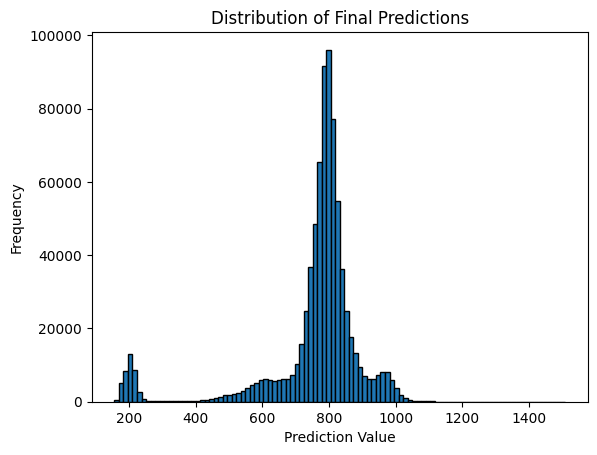

In [16]:
# Distribution of final predictions for submission
plt.hist(final_predictions, bins=100, edgecolor='k')
plt.title('Distribution of Final Predictions')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()

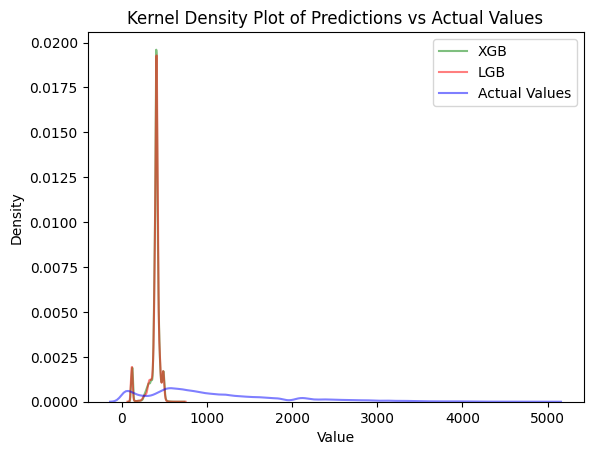

In [17]:
# Distribution of training data predictions vs actual (log1p transformed)
train_pred_xgb = np.expm1(xgb_train_pred)
train_pred_lgb = np.expm1(lgb_train_pred)
train_actual = np.expm1(y)

sns.kdeplot(train_pred_xgb, label='XGB', color='green', fill=False, alpha=0.5)
sns.kdeplot(train_pred_lgb, label='LGB', color='red', fill=False, alpha=0.5)
sns.kdeplot(train_actual, label='Actual Values', color='blue', fill=False, alpha=0.5)

plt.title('Kernel Density Plot of Predictions vs Actual Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [18]:
# Calculate variance
var_xgb = np.var(train_pred_xgb)
var_lgb = np.var(train_pred_lgb)
var_actual = np.var(train_actual)

# Print variances
print(f"Variance of XGB predictions: {var_xgb:.5f}")
print(f"Variance of LGB predictions: {var_lgb:.5f}")
print(f"Variance of Actual values: {var_actual:.5f}")

Variance of XGB predictions: 5464.80288
Variance of LGB predictions: 5478.22007
Variance of Actual values: 748222.40212


In [19]:
# Optuna Hyperparam Tuning (XGB)
def objective_xgb(trial):
    params = { 
        'device': 'cuda',
        'objective': 'reg:squarederror',
        'max_depth': 7,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.015),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_jobs': -1,
        'random_state': 42,
        'tree_method': 'gpu_hist'
    }

    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmsle = 0

    # Loop through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data into training and validation sets for this fold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Initialize the model with the current hyperparameters
        model_xgb = xgb.XGBRegressor(**xgb_params)
        model_xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            verbose=False)

        # Make predictions on validation set
        y_pred_xgb = model_xgb.predict(X_val)
        fold_rmsle_score = rmse(y_val, y_pred_xgb)
        fold_rmsle += fold_rmsle_score
        
    # Compute average RMSLE across all folds
    avg_rmsle = fold_rmsle / 5
    print(f"Average RMSLE across 5 folds: {avg_rmsle:.5f}")
    return avg_rmsle
'''
# Initialize the Optuna study
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)
best_params_xgb = study_xgb.best_params
print("Best XGB hyperparameters:", best_params_xgb)
'''

'\n# Initialize the Optuna study\nstudy_xgb = optuna.create_study(direction=\'minimize\')\nstudy_xgb.optimize(objective_xgb, n_trials=50)\nbest_params_xgb = study_xgb.best_params\nprint("Best XGB hyperparameters:", best_params_xgb)\n'

In [20]:
# Optuna Hyperparam Tuning (LGB)
def objective_lgb(trial):
    params = { 
        'objective': 'regression',
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_bin': trial.suggest_int('max_bin', 100, 500),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'gpu'
    }

    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmsle = 0

    # Loop through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data into training and validation sets for this fold
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Initialize the model with the current hyperparameters
        model_lgb = lgb.LGBMRegressor(**lgb_params)
        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse')

        # Make predictions on validation set
        y_pred_lgb = model_lgb.predict(X_val)
        fold_rmsle_score = rmse(y_val, y_pred_lgb)
        fold_rmsle += fold_rmsle_score
        
    # Compute average RMSLE across all folds
    avg_rmsle = fold_rmsle / 5
    print(f"Average RMSLE across 5 folds: {avg_rmsle:.5f}")
    return avg_rmsle

'''
# Initialize the Optuna study
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)
best_params_lgb = study_lgb.best_params
print("Best LGB hyperparameters:", best_params_lgb)
'''

'\n# Initialize the Optuna study\nstudy_lgb = optuna.create_study(direction=\'minimize\')\nstudy_lgb.optimize(objective_lgb, n_trials=50)\nbest_params_lgb = study_lgb.best_params\nprint("Best LGB hyperparameters:", best_params_lgb)\n'

In [21]:
dfSubmission.head(10)

,id,Premium Amount
0,1200000,764.589603
1,1200001,801.525132
2,1200002,786.637019
3,1200003,792.467959
4,1200004,756.284157
5,1200005,795.446659
6,1200006,974.761486
7,1200007,703.917373
8,1200008,206.428508
9,1200009,826.120179
